In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# ---------------------- Dataset Class ----------------------

In [2]:
class SaliencyDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# ---------------------- Paths & Setup ----------------------

In [3]:
# folder paths
image_dir = r"/home/user/dsr_project/dataset/Co-registered/Simulated dataset/images/RGB"
mask_dir = r"/home/user/dsr_project/dataset/Co-registered/Simulated dataset/saliency_masks"

# Match image and mask files
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg") or f.endswith(".png")])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".jpg") or f.endswith(".png")])

# Split 
train_imgs, test_imgs, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = SaliencyDataset(train_imgs, train_masks, transform=transform)
test_dataset = SaliencyDataset(test_imgs, test_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ---------------------- Defined Model ----------------------

In [4]:
class SimpleSaliencyNet(nn.Module):
    def __init__(self):
        super(SimpleSaliencyNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# ---------------------- Training Setup ----------------------

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleSaliencyNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------- Training Loop ----------------------

In [6]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/100], Loss: 0.1729
Epoch [2/100], Loss: 0.1209
Epoch [3/100], Loss: 0.1105
Epoch [4/100], Loss: 0.1018
Epoch [5/100], Loss: 0.0966
Epoch [6/100], Loss: 0.0879
Epoch [7/100], Loss: 0.0800
Epoch [8/100], Loss: 0.0731
Epoch [9/100], Loss: 0.0646
Epoch [10/100], Loss: 0.0618
Epoch [11/100], Loss: 0.0583
Epoch [12/100], Loss: 0.0539
Epoch [13/100], Loss: 0.0491
Epoch [14/100], Loss: 0.0483
Epoch [15/100], Loss: 0.0469
Epoch [16/100], Loss: 0.0447
Epoch [17/100], Loss: 0.0409
Epoch [18/100], Loss: 0.0415
Epoch [19/100], Loss: 0.0389
Epoch [20/100], Loss: 0.0369
Epoch [21/100], Loss: 0.0370
Epoch [22/100], Loss: 0.0346
Epoch [23/100], Loss: 0.0343
Epoch [24/100], Loss: 0.0329
Epoch [25/100], Loss: 0.0334
Epoch [26/100], Loss: 0.0308
Epoch [27/100], Loss: 0.0295
Epoch [28/100], Loss: 0.0308
Epoch [29/100], Loss: 0.0307
Epoch [30/100], Loss: 0.0283
Epoch [31/100], Loss: 0.0291
Epoch [32/100], Loss: 0.0267
Epoch [33/100], Loss: 0.0259
Epoch [34/100], Loss: 0.0256
Epoch [35/100], Loss: 0

# ---------------------- Visualization ----------------------

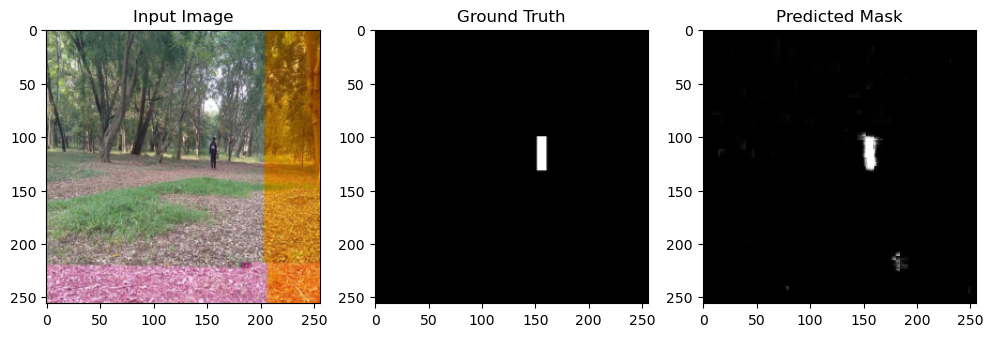

In [7]:
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        # Visualize first sample
        output_np = outputs[0][0].cpu().numpy()
        mask_np = masks[0][0].cpu().numpy()
        image_np = images[0].permute(1, 2, 0).cpu().numpy()

        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(image_np)
        ax[0].set_title("Input Image")
        ax[1].imshow(mask_np, cmap='gray')
        ax[1].set_title("Ground Truth")
        ax[2].imshow(output_np, cmap='gray')
        ax[2].set_title("Predicted Mask")
        plt.show()
        break